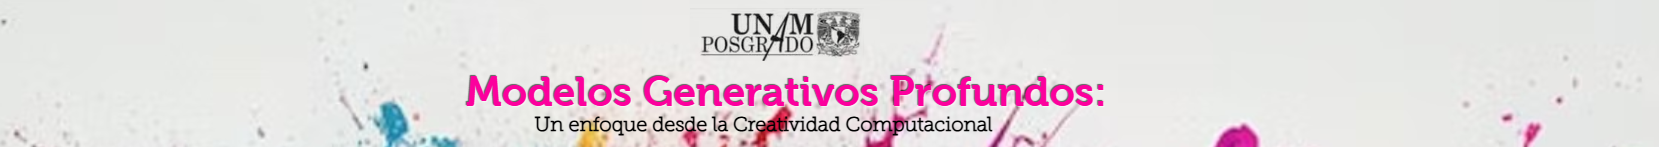


# Transfer Learning con Keras (ResNet50) — Cats vs Dogs


Este notebook muestra un flujo completo de *transfer learning*:
1) Cargar **Cats vs Dogs** desde `tensorflow_datasets`  
2) Preparar *pipelines* con **data augmentation**  
3) Usar **ResNet50 (ImageNet)** como *backbone*  
4) Entrenar en dos fases: **feature extraction** → **fine-tuning**  
5) Evaluar métricas


In [ ]:
import math, os, numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt

## 1. Cargar Cats vs Dogs (TFDS)

In [ ]:

import tensorflow_datasets as tfds

# Cargar dataset en tres splits
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.L9BA4L_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


## 2. Preprocesamiento y división en batches

In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.float32)

ds_train = (
    ds_train
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(8192, seed=123)              # baraja ejemplos (solo train)
    .batch(BATCH_SIZE)                    # agrupa en lotes
    .prefetch(AUTOTUNE)                   # prepara el siguiente lote en paralelo
)

ds_val = (
    ds_val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_test = (
    ds_test
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

### Vista rápida de algunas imágenes (opcional)

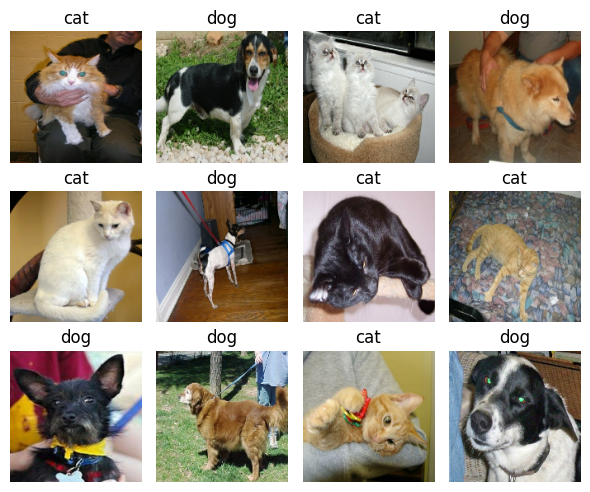

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Tomar un batch del dataset
images, labels = next(iter(ds_train))

plt.figure(figsize=(6, 5))
for i in range(12):
    plt.subplot(3, 4, i + 1)

    # Escalar de [0,1] a [0,255] y convertir a uint8
    img = tf.cast(images[i] * 255.0, tf.uint8).numpy()

    plt.imshow(img)
    plt.title("dog" if int(labels[i].numpy()) == 1 else "cat")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 3. Modelo: ResNet50 como *backbone* + nuevo *head*

In [ ]:
LEARNING_RATE_FE = 1e-3
LEARNING_RATE_FT = 1e-4

# 1. Bloque de aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# 2. Modelo base
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

# 3. Construcción del modelo completo
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_FE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 160, 160,  │          0 │ sequential[0][0]  │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 160, 160)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 160, 160)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 160, 160)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 160, 160,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 160,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4. Entrenamiento Fase 1 — *Feature Extraction* (solo el head)

Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 72s 101ms/step - accuracy: 0.9197 - loss: 0.1912 - val_accuracy: 0.9805 - val_loss: 0.0554
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.9660 - loss: 0.0935 - val_accuracy: 0.9788 - val_loss: 0.0653
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9684 - loss: 0.0829 - val_accuracy: 0.9788 - val_loss: 0.0568
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9686 - loss: 0.0857 - val_accuracy: 0.9819 - val_loss: 0.0577
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9676 - loss: 0.0860 - val_accuracy: 0.9819 - val_loss: 0.0570


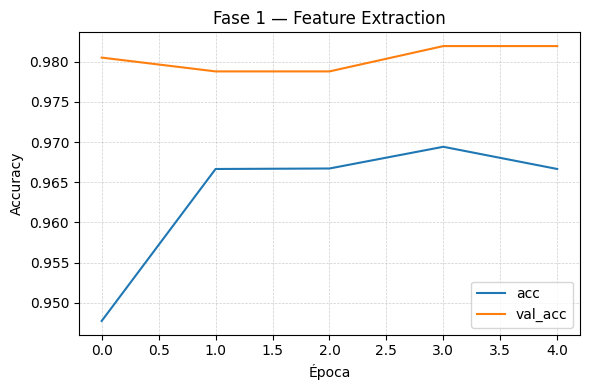

In [ ]:
EPOCHS_FE = 5         # feature extraction

history_fe = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS_FE
)


plt.figure(figsize=(6,4))
plt.plot(history_fe.history["accuracy"], label="acc")
plt.plot(history_fe.history["val_accuracy"], label="val_acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Fase 1 — Feature Extraction")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout(); plt.show()


## 5. Entrenamiento Fase 2 — *Fine-Tuning* (descongelar parte de la base)

Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 176ms/step - accuracy: 0.9533 - loss: 0.1228 - val_accuracy: 0.9819 - val_loss: 0.0589
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 96s 169ms/step - accuracy: 0.9801 - loss: 0.0480 - val_accuracy: 0.9837 - val_loss: 0.0513
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 95s 168ms/step - accuracy: 0.9886 - loss: 0.0322 - val_accuracy: 0.9805 - val_loss: 0.0552
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 95s 169ms/step - accuracy: 0.9897 - loss: 0.0269 - val_accuracy: 0.9862 - val_loss: 0.0457
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 98s 175ms/step - accuracy: 0.9911 - loss: 0.0213 - val_accuracy: 0.9868 - val_loss: 0.0408


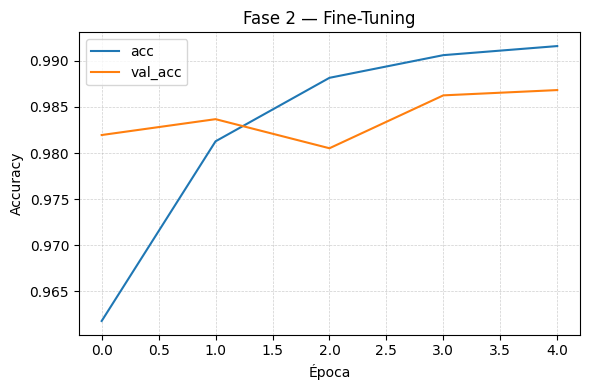

In [ ]:
EPOCHS_FT = 5         # fine-tuning
FINE_TUNE_AT = 100    # número de capas a congelar al inicio del fine-tuning

base_model.trainable = True
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_FT),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS_FT
    #callbacks=cbs_ft
)

plt.figure(figsize=(6,4))
plt.plot(history_ft.history["accuracy"], label="acc")
plt.plot(history_ft.history["val_accuracy"], label="val_acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Fase 2 — Fine-Tuning")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout(); plt.show()


## 6. Evaluación en test y matriz de confusión

Test accuracy: 0.9831
Confusion matrix:\n [[1681   39]
 [  20 1749]]
\nClassification report:\n               precision    recall  f1-score   support

         cat       0.99      0.98      0.98      1720
         dog       0.98      0.99      0.98      1769

    accuracy                           0.98      3489
   macro avg       0.98      0.98      0.98      3489
weighted avg       0.98      0.98      0.98      3489



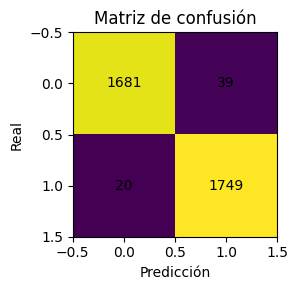

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_true, y_pred = [], []
for images, labels in ds_test:
    preds = model.predict(images, verbose=0).ravel()
    y_pred.extend((preds >= 0.5).astype(int))
    y_true.extend(labels.numpy().astype(int))

y_true = np.array(y_true); y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\\n", cm)
print("\\nClassification report:\\n", classification_report(y_true, y_pred, target_names=["cat","dog"]))

import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.imshow(cm)
plt.title("Matriz de confusión"); plt.xlabel("Predicción"); plt.ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout(); plt.show()
